In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline


import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-06-10 05:16:48.394722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749532608.607693      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749532608.672660      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_files=[]
mask_files=glob(pathname="/kaggle/input/d/mateuszbuda/lgg-mri-segmentation/kaggle_3m/*/*_mask*")

for file in mask_files:
  image_files.append(file.replace("_mask",""))

print(len(image_files),len(mask_files))

3929 3929


In [6]:
print(image_files[0])
print(mask_files[0])

/kaggle/input/d/mateuszbuda/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif
/kaggle/input/d/mateuszbuda/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif


In [7]:
def plot_img_mask(image_files,mask_files):
    for i in range(10):
        plt.figure(figsize  = (6,4))
        img_path = image_files[i]
        mask_path = mask_files[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
        plt.show()

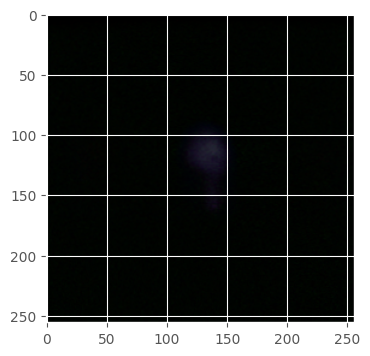

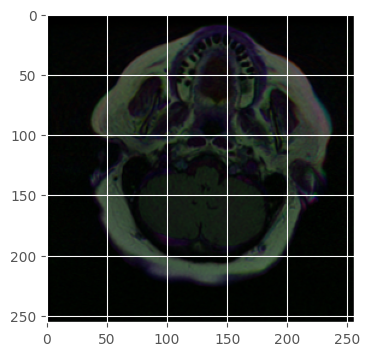

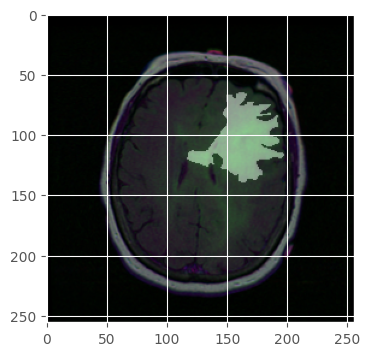

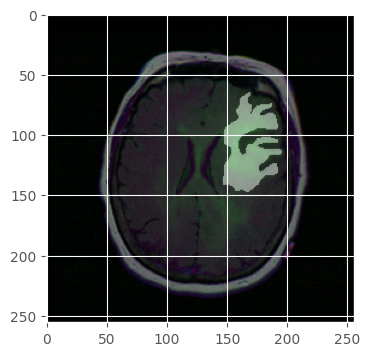

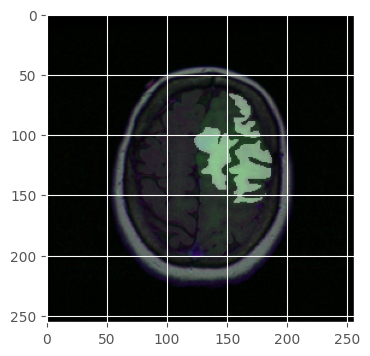

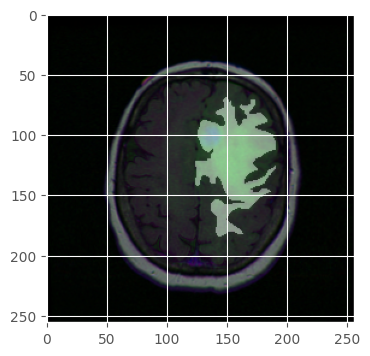

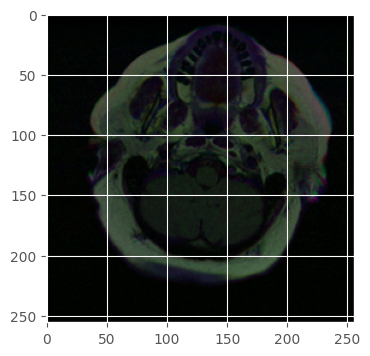

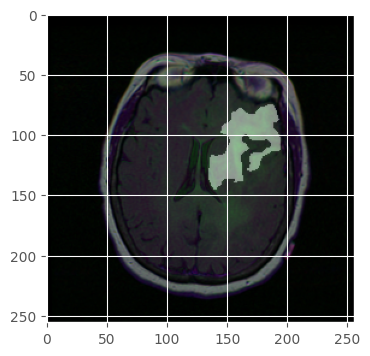

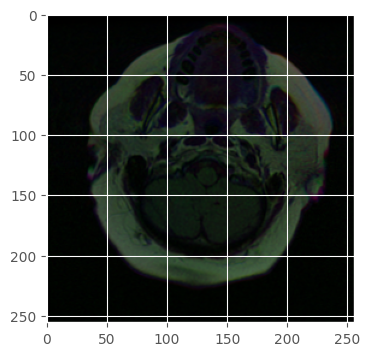

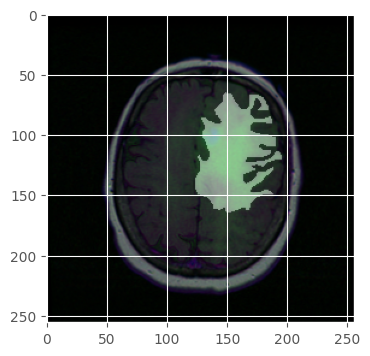

In [8]:
plot_img_mask(image_files,mask_files)

In [9]:
df=pd.DataFrame(data={'image':image_files,'mask':mask_files})
print(df.head(3))

                                               image  \
0  /kaggle/input/d/mateuszbuda/lgg-mri-segmentati...   
1  /kaggle/input/d/mateuszbuda/lgg-mri-segmentati...   
2  /kaggle/input/d/mateuszbuda/lgg-mri-segmentati...   

                                                mask  
0  /kaggle/input/d/mateuszbuda/lgg-mri-segmentati...  
1  /kaggle/input/d/mateuszbuda/lgg-mri-segmentati...  
2  /kaggle/input/d/mateuszbuda/lgg-mri-segmentati...  


In [10]:
train_data,test_data=train_test_split(df,test_size=0.2,random_state=5)
train_data,validation_data=train_test_split(train_data,test_size=0.05,random_state=7)
print(train_data.shape)
print(test_data.shape)
print(validation_data.shape)

(2985, 2)
(786, 2)
(158, 2)


In [11]:
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [12]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image_prefix",
    mask_save_prefix="mask_prefix",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)


In [13]:
def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

In [15]:
def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)

In [16]:
def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [17]:
def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)

In [18]:
im_width=256
im_height=256

In [19]:
def unet(input_size=(256,256,3)):

    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    # First DownSampling
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
    #Second DownSampling
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)
    # Third DownSampling
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6),conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7),conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8),conv1],axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [20]:
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(train_data, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))

test_gener = train_generator(validation_data, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, 3))



# decay_rate = learning_rate / EPOCHS
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.h5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=int(len(train_data) // BATCH_SIZE),
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=int(len(validation_data) // BATCH_SIZE))

I0000 00:00:1749533150.585419      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749533150.586099      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 2985 validated image filenames.
Found 2985 validated image filenames.
Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)
I0000 00:00:1749533177.402422     119 service.cc:148] XLA service 0x793c54005a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749533177.403463     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749533177.403482     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749533178.719149     119 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-10 05:26:26.216456: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8290 - dice_coefficients: 0.0806 - iou: 0.0427 - loss: -0.0806Found 158 validated image filenames.
Found 158 validated image filenames.

Epoch 1: val_loss improved from inf to -0.01705, saving model to unet_brain_mri_seg.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - binary_accuracy: 0.8299 - dice_coefficients: 0.0810 - iou: 0.0429 - loss: -0.0810 - val_binary_accuracy: 0.9917 - val_dice_coefficients: 0.0170 - val_iou: 0.0087 - val_loss: -0.0170
Epoch 2/150


E0000 00:00:1749533501.762127     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749533501.993536     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749533509.674843     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749533509.989275     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749533519.036153     122 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9838 - dice_coefficients: 0.1892 - iou: 0.1062 - loss: -0.1866
Epoch 2: val_loss improved from -0.01705 to -0.02345, saving model to unet_brain_mri_seg.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - binary_accuracy: 0.9839 - dice_coefficients: 0.1894 - iou: 0.1063 - loss: -0.1869 - val_binary_accuracy: 0.9893 - val_dice_coefficients: 0.0235 - val_iou: 0.0120 - val_loss: -0.0235
Epoch 3/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9891 - dice_coefficients: 0.2291 - iou: 0.1316 - loss: -0.2347

E0000 00:00:1749533899.658811     121 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749533899.918943     121 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 3: val_loss improved from -0.02345 to -0.03439, saving model to unet_brain_mri_seg.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - binary_accuracy: 0.9891 - dice_coefficients: 0.2293 - iou: 0.1318 - loss: -0.2349 - val_binary_accuracy: 0.9905 - val_dice_coefficients: 0.0348 - val_iou: 0.0181 - val_loss: -0.0344
Epoch 4/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9915 - dice_coefficients: 0.3196 - iou: 0.1932 - loss: -0.3168
Epoch 4: val_loss improved from -0.03439 to -0.20112, saving model to unet_brain_mri_seg.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - binary_accuracy: 0.9915 - dice_coefficients: 0.3197 - iou: 0.1932 - loss: -0.3169 - val_binary_accuracy: 0.9924 - val_dice_coefficients: 0.2011 - val_iou: 0.1140 - val_loss: -0.2011
Epoch 5/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9925 - dice_coefficients: 0.3712 - iou: 0.2312 - loss: -0.3679
Epoch 5: val_loss improved from -0.20112 to -0.34434, saving model to unet_brain_mri_seg.h5
93/93 ━

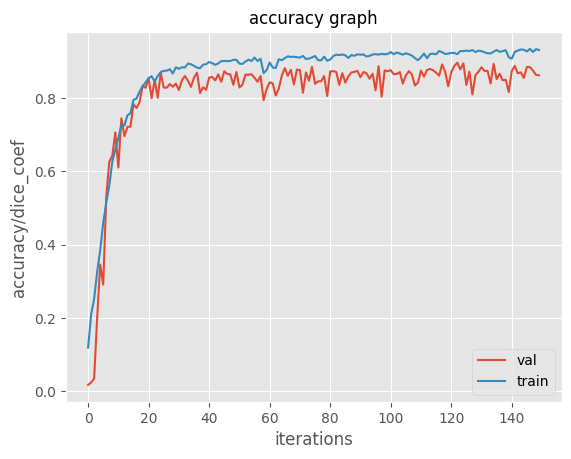

In [24]:
history_post_training = history.history

train_accuracy = history_post_training['dice_coefficients']
val_accuracy = history_post_training['val_dice_coefficients']

plt.figure()
plt.plot(val_accuracy,label="val")
plt.plot(train_accuracy,label="train")

plt.xlabel('iterations')
plt.ylabel('accuracy/dice_coef')
plt.title('accuracy graph', fontsize=12)
plt.legend()

plt.show()

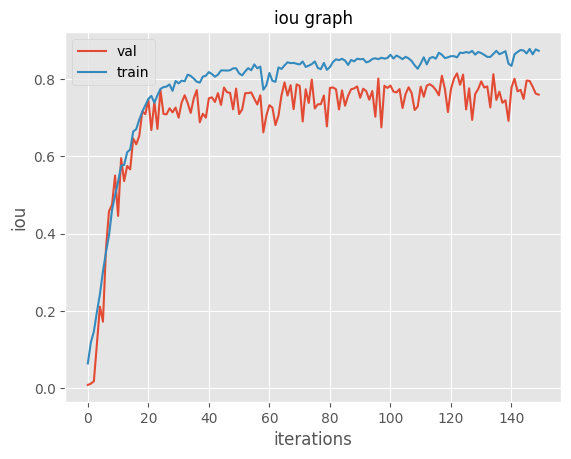

In [26]:
history_post_training = history.history

train_accuracy = history_post_training['iou']
val_accuracy = history_post_training['val_iou']

plt.figure()
plt.plot(val_accuracy,label="val")
plt.plot(train_accuracy,label="train")

plt.xlabel('iterations')
plt.ylabel('iou')
plt.title('iou graph', fontsize=12)
plt.legend()

plt.show()

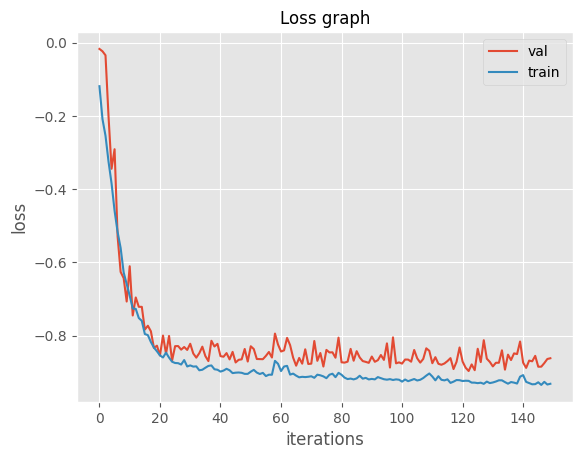

In [30]:
history_post_training = history.history

train_loss = history_post_training['loss']
val_loss = history_post_training['val_loss']

plt.figure()
plt.plot(val_loss,label="val")
plt.plot(train_loss,label="train")

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss graph', fontsize=12)
plt.legend()

plt.show()


In [31]:
model = load_model('unet_brain_mri_seg.h5', compile=False)

# Now recompile manually
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_coefficients_loss,
    metrics=["binary_accuracy", iou, dice_coefficients]
)


In [32]:
test_gen = train_generator(test_data, BATCH_SIZE, dict(), target_size=(im_height,im_width))

results = model.evaluate(test_gen, steps = int(len(test_data)//BATCH_SIZE))
print('Test Loss', results[0])
print('Test IOU', results[1])
print('Test Dice Coeff', results[2])

Found 786 validated image filenames.
Found 786 validated image filenames.
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 584ms/step - binary_accuracy: 0.9982 - dice_coefficients: 0.9060 - iou: 0.8293 - loss: -0.9060
Test Loss -0.905748188495636
Test IOU 0.9982800483703613
Test Dice Coeff 0.8291840553283691


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


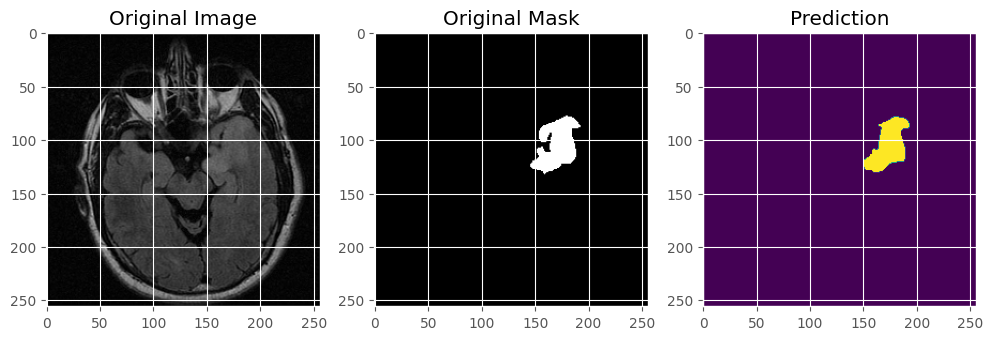

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


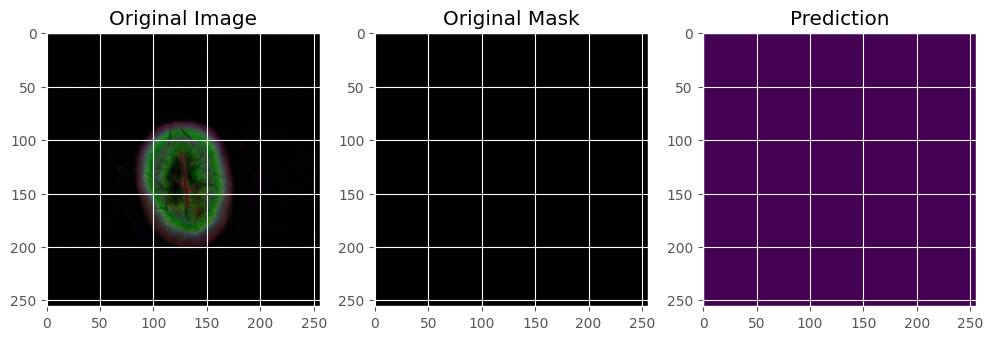

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


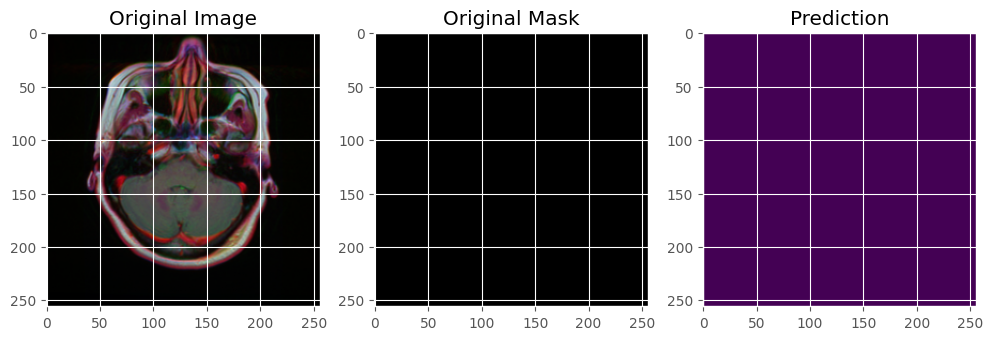

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


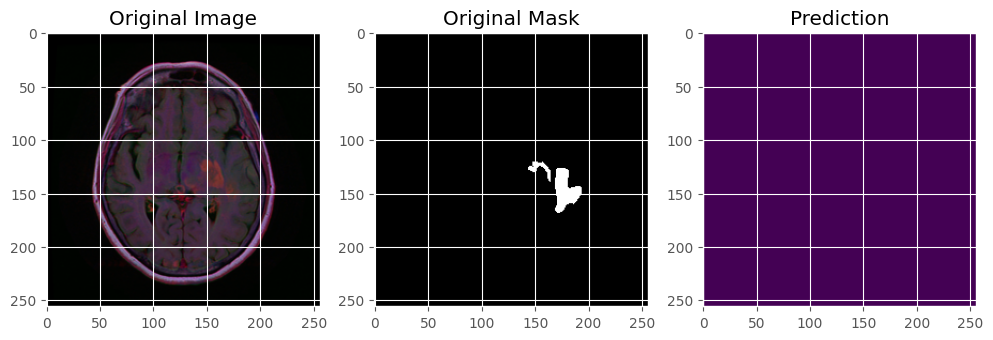

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


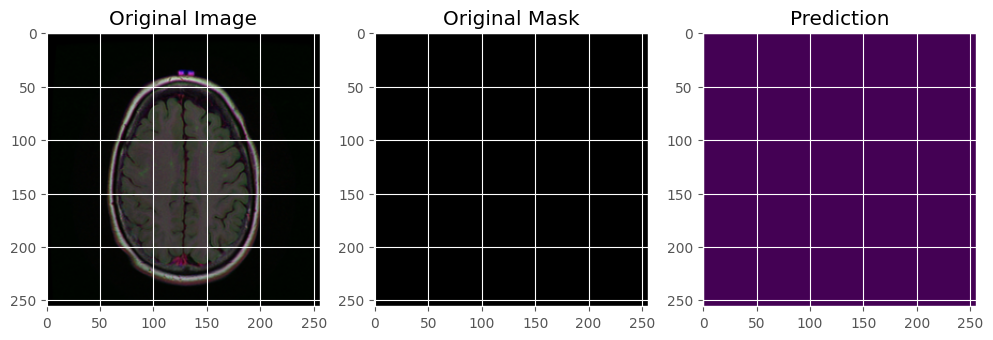

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


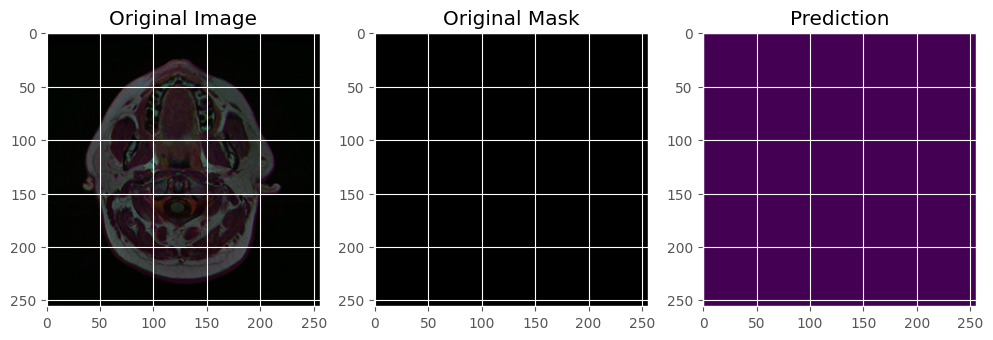

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


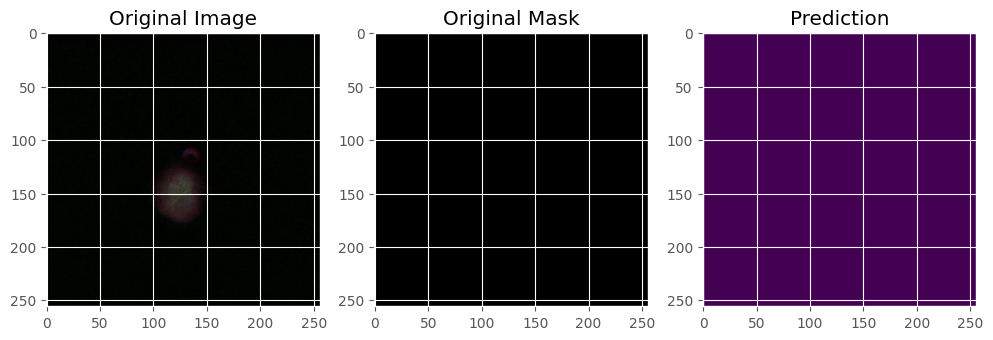

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


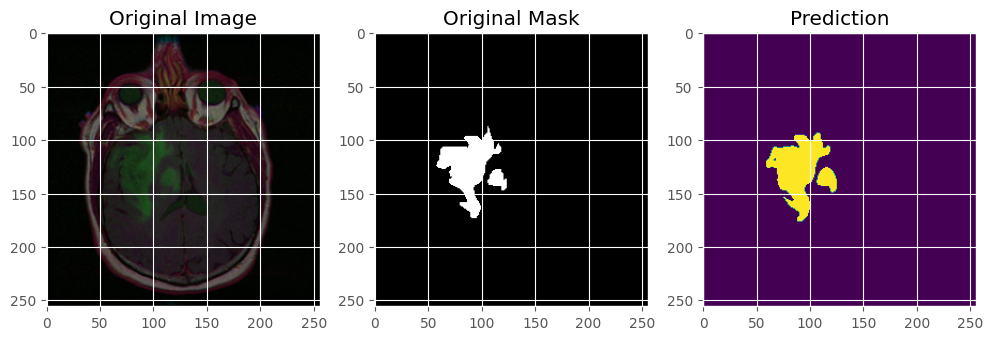

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


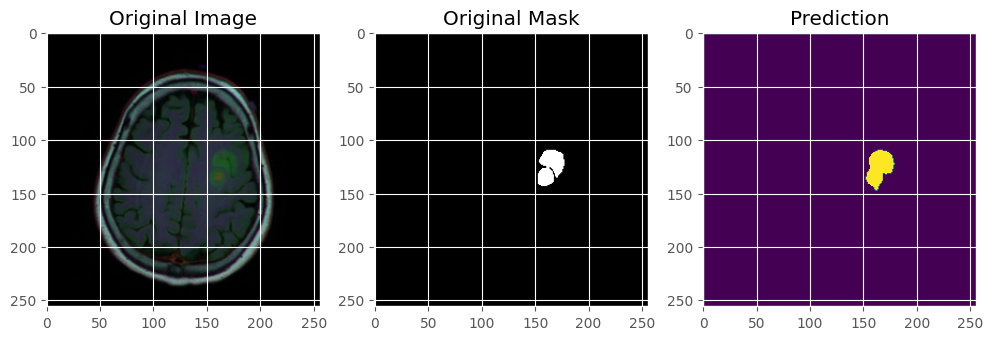

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


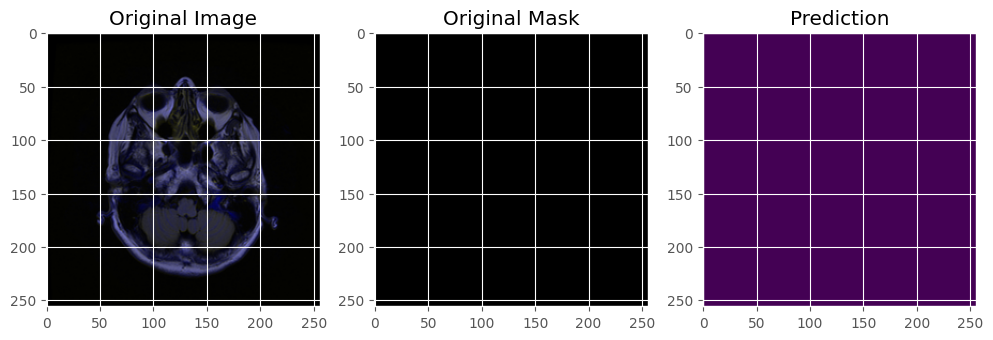

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


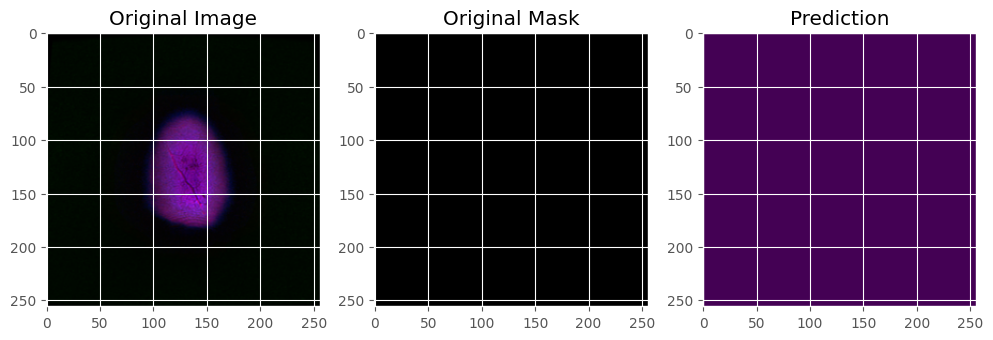

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


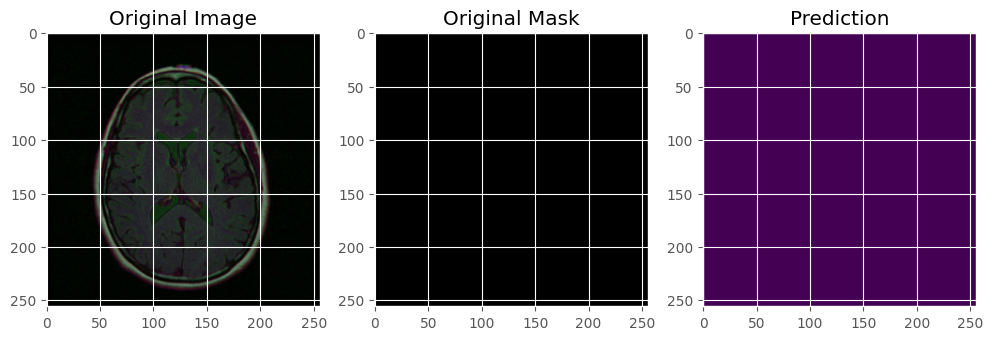

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


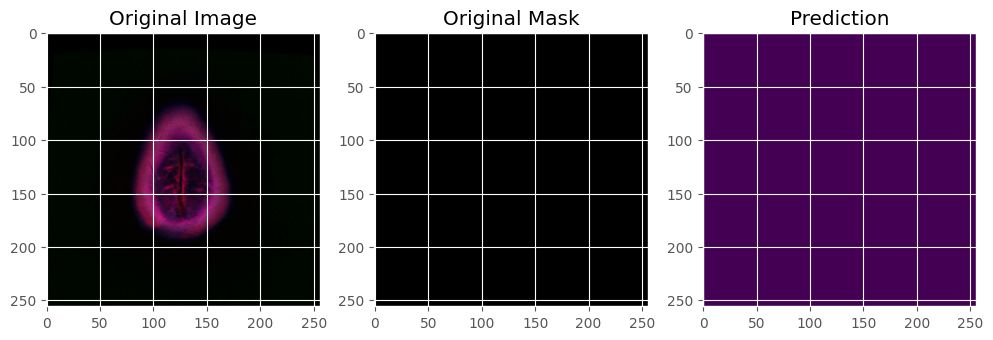

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


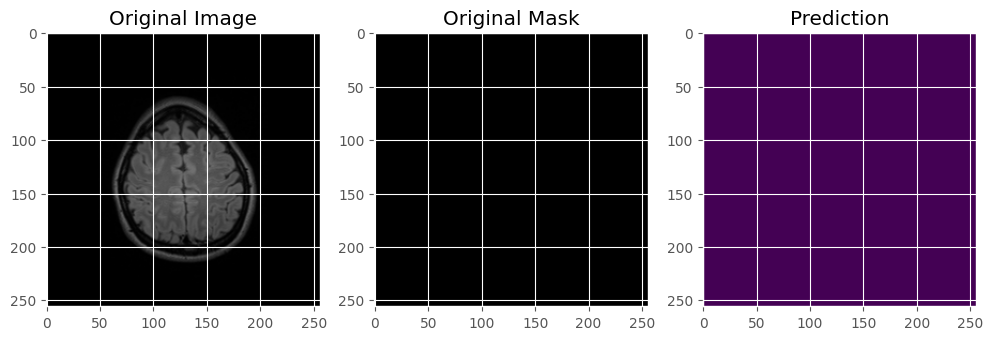

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


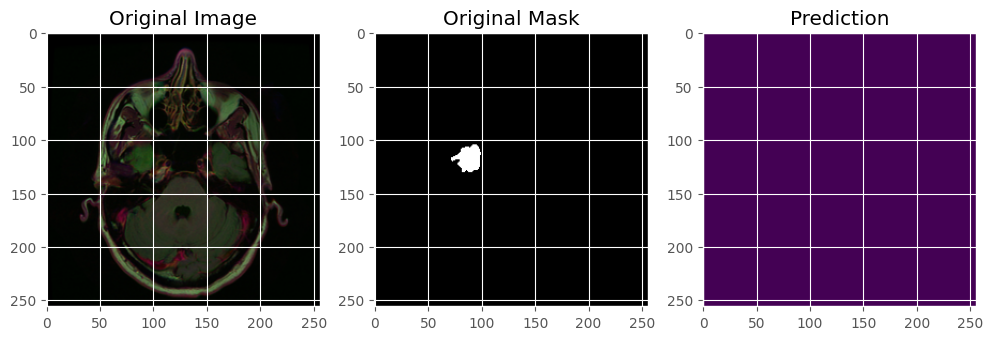

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


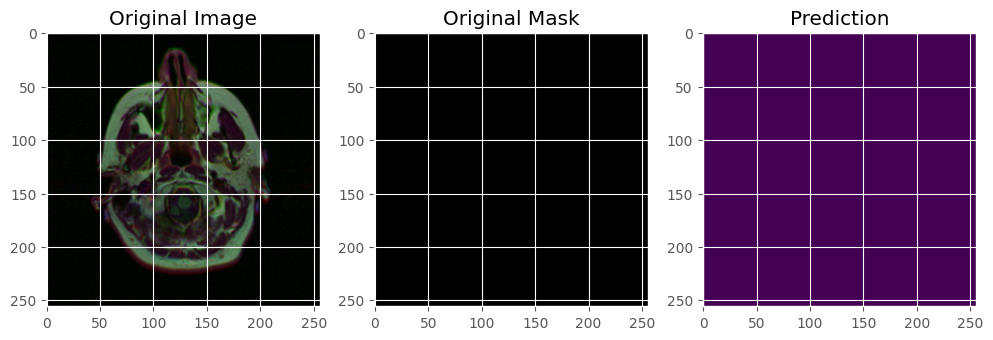

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


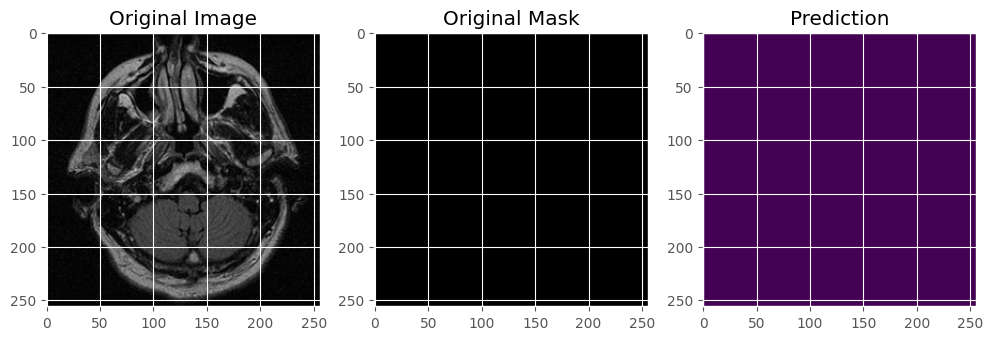

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


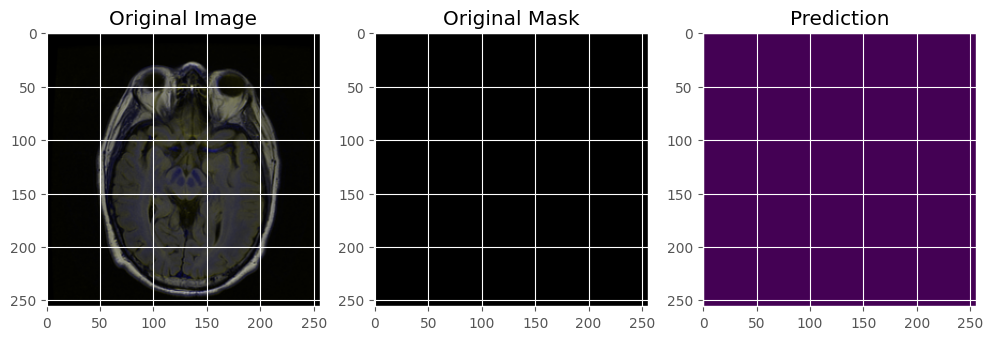

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


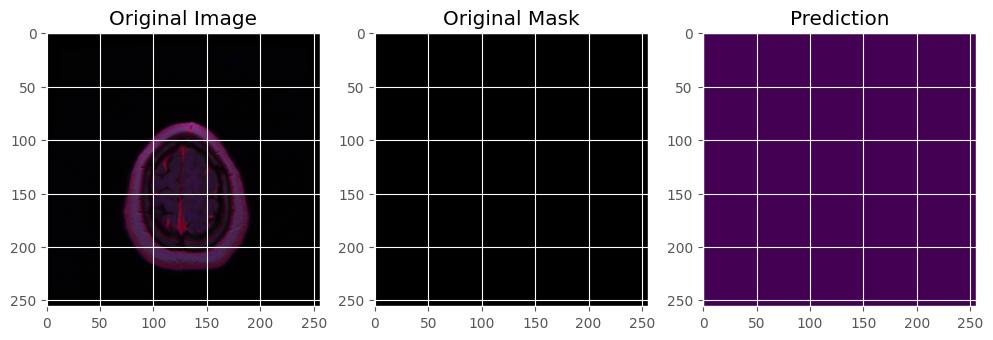

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


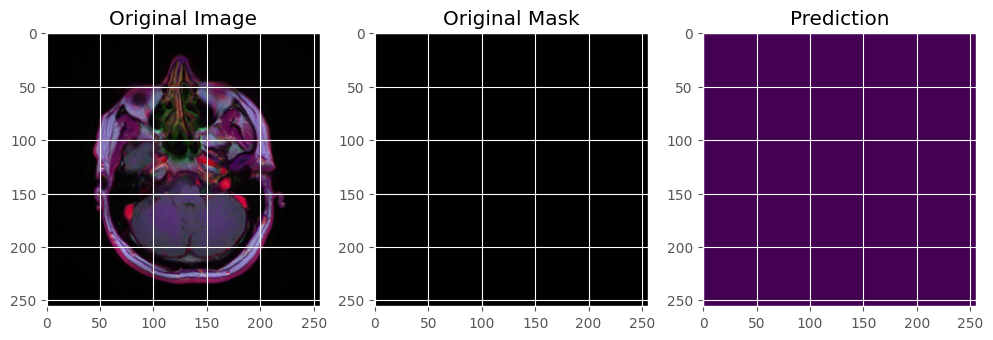

In [33]:
for i in range(20):
    index = np.random.randint(1, len(test_data.index))
    img = cv2.imread(test_data['image'].iloc[index])
    img = cv2.resize(img, (im_height,im_width))
    img = img/255
    img = img[np.newaxis, : ,:, :]
    pred_img = model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_data['mask'].iloc[index])))
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img) > 0.5)
    plt.title("Prediction")
    plt.show()